In [1]:
from os import path, listdir, mkdir
from os.path import join
import os
from torch_geometric.data import HeteroData
import json
import warnings
from tqdm import tqdm
import pandas as pd
import torch
import pickle as pkl

/home/ma952/.conda/envs/sets/lib/python3.9/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [2]:
# check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


ENVIRONMENT VARIABLES

In [3]:
data_path = "../unarXiv"
YEARS = ['00', '01']
CATEGORIES = ["cs.AI", "cs.CL", "cs.CV", "cs.LG", "stat.ML"]
PAPERS_BY_CATEGORY = True
AUTHOR_PAST_YEARS = 5
PREDICT_FOR_YEARS = 4
DATASET_LAST_YEAR = 2022

In [4]:
def read_jsonl(file_path):
    with open(file_path, "r") as f:
        data = [json.loads(line) for line in f]
    return data

In [5]:
os.getcwd()

'/home/ma952/Sets/2023sp_cs6850_network/WMRRank'

In [ ]:
# papers = read_jsonl(join(data_path, str(folder), files))
# for paper in papers: 
#     metadata = paper.get('metadata', {})
#     if metadata.get('authors_parsed'):
#         print(metadata['authors_parsed'])

In [ ]:
# for cited_paper_id, cited_paper_info in paper["bib_entries"].items():
#     if cited_paper_info.get('contained_arXiv_ids'):
#         # print(len(cited_paper_info['contained_arXiv_ids']))
#         cited_paper_ids.append(cited_paper_info['contained_arXiv_ids'][0].get('id')) # 1 Paper at a time 
#         # print(cited_paper_info['contained_arXiv_ids'][0].get('id'))

PRE-PROCESSING

In [6]:
warnings.filterwarnings('ignore')
total_papers = 0
authors = []
papers = []
paper_info = pd.DataFrame(columns=['paper_id', 'title', 'authors', 'cited_paper_ids'])
for folder in listdir(data_path):
    if folder in YEARS:
        print(folder, os.path.join(data_path, str(folder)))
        if folder[0] == "9":
            year = "19" + folder
        else:
            year = "20" + folder
        for files in tqdm(listdir(join(data_path, str(folder)))):
            papers_read = read_jsonl(join(data_path, str(folder), files))
            total_papers += len(papers_read)
            for paper in papers_read:
                
                cited_paper_ids = []
                author_names = []
                metadata = paper.get('metadata', {})
                
                if metadata.get('title') and metadata.get('authors_parsed'):
                    
                    paper_title = metadata['title']
                    paper_id = paper["paper_id"]
                    found_match = (not PAPERS_BY_CATEGORY)
                    if metadata.get('categories') and PAPERS_BY_CATEGORY:
                        categories = metadata['categories'].split(' ')
                        found_match = any([cat in CATEGORIES for cat in categories])
                    
                    if found_match:
                        
                        papers.append(paper_id) # 1 Paper
                        
                        for cited_paper_id, cited_paper_info in paper["bib_entries"].items():
                            if 'ids' not in cited_paper_info:
                                continue
                            elif 'arxiv_id' not in cited_paper_info['ids']:
                                continue
                            else:
                                ref_paper_id = cited_paper_info['ids']['arxiv_id']
                                if ref_paper_id == '':
                                    continue
                                cited_paper_ids.append(ref_paper_id)
                        papers.extend(cited_paper_ids)
                        
                        if metadata.get('authors_parsed'):
                            
                            authors_parsed = metadata['authors_parsed']
                            
                            # Consider only top 5 authors
                            for author in authors_parsed[:5]:
                                author = author[:2]
                                author_parsed = " ".join(author)
                                author_names.append(author_parsed)
                                
                            author_names = list(set(author_names))
                            authors.extend(author_names) # Multiple authors at a time
                            
                        paper_info = paper_info.append({'paper_id': paper_id, 'title': paper_title, 'authors': author_names, 'cited_paper_ids': cited_paper_ids, 'year': year}, ignore_index=True)

00 ../unarXiv/00


100%|███████████████████████████████████████████| 12/12 [01:02<00:00,  5.18s/it]


01 ../unarXiv/01


100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.50s/it]


In [7]:
authors_pd = pd.DataFrame(authors)
authors_pd = authors_pd.drop_duplicates()
papers_pd = pd.DataFrame(papers)
papers_pd = papers_pd.drop_duplicates()

In [8]:
paper_info.to_csv('paper_info.csv', index=False)
papers_pd.to_csv('papers.csv', index=False, header=False)
authors_pd.to_csv('authors.csv', index=False, header=False)

In [9]:
pd.__version__
torch.__version__

'2.0.1+cu117'

In [10]:
print(authors_pd)
print(papers_pd)

                         0
0    Shalizi Cosma Rohilla
1     Crutchfield James P.
2          O'Rourke Joseph
3                Prasad L.
4             Schlei B. R.
..                     ...
595        Swinnen Gilbert
596              Brijs Tom
597          Goethals Bart
599    Bussche Jan Van den
600          Geerts Floris

[379 rows x 1 columns]
              0
0    cs/0001027
1    cs/0001025
2    cs/0001024
3    cs/0001023
4    cs/0001022
..          ...
353  cs/0112011
354  cs/0112007
355  cs/0112005
357  cs/0112004
358  cs/0112003

[319 rows x 1 columns]


In [11]:
print(len(authors))

612


In [12]:
# for i,v in paper_info.iterrows():
#     print(v['paper_id'])

In [13]:
unique_paper_id = papers_pd[0].unique()
unique_paper_id = pd.DataFrame(data={
    'paperId': unique_paper_id,
    'mappedID': pd.RangeIndex(len(unique_paper_id)),
})
print("Mapping of paper IDs to consecutive values:")
print("==========================================")
print(unique_paper_id.head())
print()
unique_paper_id.to_csv('unique_paper_id.csv', index=False, header=False)

# for i,v in unique_paper_id.iterrows():
#     print(v)

# unique_author_id = authors_pd[0].unique()
# unique_author_id = pd.DataFrame(data={
#     'authorId': unique_author_id,
#     'mappedID': pd.RangeIndex(len(unique_author_id)),
# })
# print("Mapping of author IDs to consecutive values, remember each author in a year is treated as a new entity:")
# print("==========================================")
# print(unique_author_id.head())
# print()

Mapping of paper IDs to consecutive values:
      paperId  mappedID
0  cs/0001027         0
1  cs/0001025         1
2  cs/0001024         2
3  cs/0001023         3
4  cs/0001022         4



GENERATING THE HETEROGENOUS GRAPH

In [14]:
paper_info_2 = paper_info.explode('authors')
paper_exploded = paper_info_2.reset_index(drop=True)
paper_exploded['position'] = paper_exploded.groupby(['paper_id', 'title']).cumcount() + 1
paper_info_2 = paper_exploded

In [23]:
paper_info_2

,paper_id,title,authors,cited_paper_ids,year,position,authors_year
0,cs/0001027,Pattern Discovery and Computational Mechanics,Shalizi Cosma Rohilla,[],2000,1,Shalizi Cosma Rohilla_2000
1,cs/0001027,Pattern Discovery and Computational Mechanics,Crutchfield James P.,[],2000,2,Crutchfield James P._2000
2,cs/0001025,Computational Geometry Column 38,O'Rourke Joseph,[],2000,1,O'Rourke Joseph_2000
3,cs/0001024,A Parallel Algorithm for Dilated Contour Extra...,Prasad L.,[],2000,1,Prasad L._2000
4,cs/0001024,A Parallel Algorithm for Dilated Contour Extra...,Schlei B. R.,[],2000,2,Schlei B. R._2000
...,...,...,...,...,...,...,...
607,cs/0112004,Part of Speech Tagging in Thai Language Using ...,Murata Masaki,[],2001,3,Murata Masaki_2001
608,cs/0112003,Using a Support-Vector Machine for Japanese-to...,Ma Qing,[],2001,1,Ma Qing_2001
609,cs/0112003,Using a Support-Vector Machine for Japanese-to...,Isahara Hitoshi,[],2001,2,Isahara Hitoshi_2001
610,cs/0112003,Using a Support-Vector Machine for Japanese-to...,Murata Masaki,[],2001,3,Murata Masaki_2001


In [15]:
# Computing unique total entities by treating authors in new years as seperate entities
paper_info_2['authors_year'] = paper_info_2['authors'].astype(str) + '_' + paper_info_2['year'].astype(str)

total_author_entities = len(paper_info_2['authors_year'].unique())
unique_author_year_id = paper_info_2['authors_year'].unique()

unique_author_year_id = pd.DataFrame(data={
    'authorId': unique_author_year_id,
    'mappedID': pd.RangeIndex(total_author_entities),
})

print("Total number of unique author entities: ", total_author_entities)

# Using this to create the edges of the heterograph
paper_info_3 = paper_info.explode('cited_paper_ids')

Total number of unique author entities:  425


In [16]:
authors_pd_list = unique_author_year_id['authorId'].tolist()
papers_pd_list = unique_paper_id['paperId'].tolist()

In [17]:
import numpy as np

In [18]:
# print(unique_paper_id)
paper_id_info = pd.merge(paper_info_2['paper_id'], unique_paper_id, left_on='paper_id', right_on='paperId', how='left')
# print(paper_id_info)
paper_id_info = torch.from_numpy(paper_id_info['mappedID'].values)

paper_author_year_info = pd.merge(paper_info_2['authors_year'], unique_author_year_id, left_on='authors_year', right_on='authorId', how='left')
paper_author_year_info = torch.from_numpy(paper_author_year_info['mappedID'].values)

paper_author_year_weight = torch.from_numpy(paper_info_2['position'].values)
year_weight = torch.from_numpy(np.array(list(map(int,paper_info_2['year'].values))))

attr_weights = torch.stack([paper_author_year_weight.float(), year_weight.float()], dim = 0)
# for i in range(attr_weights[0].shape[0]):
#     print(attr_weights[0][i])

# Construct the paper-author edges:
paper_author_edge_index = torch.stack([paper_id_info.float(), paper_author_year_info.float()], dim=0)

paper_id_info = pd.merge(paper_info_3['paper_id'], unique_paper_id, left_on='paper_id', right_on='paperId', how='left')
paper_id_info = torch.from_numpy(paper_id_info['mappedID'].values)

paper_cite_info = pd.merge(paper_info_3['cited_paper_ids'], unique_paper_id, left_on='cited_paper_ids', right_on='paperId', how='left')
paper_cite_info = torch.from_numpy(paper_cite_info['mappedID'].values)

# Construct the paper-paper edges:
paper_cite_edge_index = torch.stack([paper_id_info.float(), paper_cite_info.float()], dim=0)

print()
print("Edge indices:")
print("=============")
print("Final edge indices pointing from Paper to author:")
print("------------------------")
print(paper_author_edge_index)
print()
print("Final edge indices pointing from Paper to cited papers:")
print("------------------------")
print(paper_cite_edge_index)
print()


Edge indices:
Final edge indices pointing from Paper to author:
------------------------
tensor([[  0.,   0.,   1.,  ..., 318., 318., 318.],
        [  0.,   1.,   2.,  ..., 284., 287., 288.]])

Final edge indices pointing from Paper to cited papers:
------------------------
tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
          13.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
          26.,  27.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
          39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
          51.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  60.,  60.,  60.,
          60.,  60.,  60.,  60.,  68.,  69.,  69.,  72.,  73.,  73.,  73.,  74.,
          75.,  76.,  78.,  79.,  80.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
          88.,  91.,  92.,  93.,  94.,  95.,  96.,  98.,  97.,  99., 100., 101.,
         103., 104., 105., 106., 107., 108., 109., 110., 112., 113., 114., 

In [19]:
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops
import torch_geometric

In [20]:
print(torch_geometric.__version__)

2.3.0


In [21]:
data = HeteroData()

data["paper"].node_id = torch.arange(len(unique_paper_id)).float()
data["author"].node_id = torch.arange(len(unique_author_year_id)).float()

data["paper", "written_by", "author"].edge_index = paper_author_edge_index
data["paper", "cites", "paper"].edge_index = paper_cite_edge_index
data["paper", "written_by", "author"].edge_attr = attr_weights

print(data)
data = data.to(device)

HeteroData(
  paper={ node_id=[319] },
  author={ node_id=[425] },
  (paper, written_by, author)={
    edge_index=[2, 612],
    edge_attr=[2, 612]
  },
  (paper, cites, paper)={ edge_index=[2, 300] }
)


## WMR RANK

In [24]:
data["paper", "written_by", "author"].edge_attr[1]

tensor([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 

In [25]:
MU = { 1991: 0.0, 1992: 0.0, 1993: 0.0, 1994: 0.0, 1995: 0.0, 1996: 0.0, 1997: 0.0, 1998: 0.0, 1999: 0.0,
       2000: 0.1, 2001: 0.1, 2002: 0.1, 2003: 0.1, 2004: 0.1, 2005: 0.1, 2006: 0.2, 2007: 0.2, 2008: 0.2, 
       2009: 0.2, 2010: 0.3, 2011: 0.4, 2012: 0.5, 2013: 0.5, 2014: 0.5, 2015: 0.5, 2016: 0.6, 2017: 0.6, 
       2018: 0.7, 2019: 0.8, 2020: 0.8, 2021: 0.8, 2022: 0.8, 2023: 0.9 }

class WMR_Rank:
    
    def __init__(self, heteroData, device):
        self.checkpoint_path = './checkpoints/'
        self.device = device
        self.pp_edge_index = heteroData['paper', 'cites', 'paper'].edge_index.to(device).to(torch.float64)
        self.pa_edge_index = heteroData['paper', 'written_by', 'author'].edge_index.to(device).to(torch.float64)
        self.pa_edge_attr = heteroData['paper', 'written_by', 'author'].edge_attr.to(device).to(torch.float64)
        
        
    def get_mapped_author_year(self, author_year):
        return torch.tensor(unique_author_year_id[unique_author_year_id['authorId'] == author_year]['mappedID'].values[0]).to(self.device)
    
    def get_mapped_paper(self, paper):
        return torch.tensor(unique_paper_id[unique_paper_id['paperId'] == paper]['mappedID'].values[0]).to(self.device)
    
    def get_unmapped_author_year(self, author_year):
        return torch.tensor(unique_author_year_id[unique_author_year_id['mappedID'] == author_year]['authorId'].values[0]).to(self.device)
    
    def get_unmapped_paper(self, paper):
        return torch.tensor(unique_paper_id[unique_paper_id['mappedID'] == paper]['paperId'].values[0]).to(self.device)
    
    def order(self, paper, author, tomap = False):
        if tomap:
            paper = self.get_mapped_paper(paper)
            author = self.get_mapped_author_year(author)
        result = self.pa_edge_attr[0][(self.pa_edge_index[0] == paper) & (self.pa_edge_index[1] == author)]
        return result.to(device)
        
    def pnai(self, AS, VA, author_year, ta):
        author = '_'.join(author_year.split('_')[:-1])
        current_year = int(author_year.split('_')[-1])
        author_perf = torch.zeros(ta).type(torch.float64).to(device)
        for i in range(ta):
            author_pass = author + '_' + str(current_year - i - 1)
            if author_pass in VA:
#                 print("PNAI: ", author_pass)
                author_perf[i] = AS[self.get_mapped_author_year(author_pass)]
        return author_perf.to(device)   
    
    def find_papers_citing_papers_until_year(self, paper, year):
        papers_cited_mapped = torch.unique(self.pp_edge_index[0][self.pp_edge_index[1] == paper])
        years_citing_papers = torch.Tensor().to(device).to(torch.float64)
        for i in papers_cited_mapped:
            years_citing_papers = torch.cat((years_citing_papers, self.paper_published_year(i)))
        years_citing_papers = years_citing_papers[years_citing_papers <= year]
        return years_citing_papers.to(device)    
    
    def find_papers_citing_paper(self, paper):
        papers_cited_mapped = torch.unique(self.pp_edge_index[0][self.pp_edge_index[1] == paper])
        return papers_cited_mapped.to(device)
    
    def recent_papers_citing_paper(self, paper, publish_year, l):
        device = self.device
        citing_papers = self.find_papers_citing_paper(paper)
        years_citing_papers = torch.Tensor().to(device).to(torch.float64)
        for i in citing_papers:
            years_citing_papers = torch.cat((years_citing_papers, self.paper_published_year(i)))
        years_citing_papers, _ = torch.sort(years_citing_papers, descending = True)
        
        if (years_citing_papers.shape[0] < l):
            extra_years = torch.full((l - years_citing_papers.shape[0], ), publish_year).to(device)
            years_citing_papers = torch.cat((years_citing_papers, extra_years))
        years_citing_papers = years_citing_papers[:l]
        return years_citing_papers.to(device)
    
    def T_pi(self, paper, current_year, sigma1):
        publish_year = int(self.paper_published_year(paper))
        evaluation_year = current_year
        l = int(evaluation_year) - publish_year
        years_citing_papers = self.recent_papers_citing_paper(paper, publish_year, l)
        years_citing_papers = years_citing_papers.to(torch.float64)
        T_avg = torch.mean(years_citing_papers).to(torch.float64)
        T_pi = torch.exp(-sigma1 * (current_year - T_avg))/ (current_year - T_avg)
        return T_pi.to(device).to(torch.float64)
    
    def T_ai(self, author_year, sigma2, current_year, m = 10):
        device = self.device
        papers = self.get_all_papers_by_author_year(author_year)
        citing_papers = torch.Tensor().to(device).to(torch.float64)
        years_citing_papers = torch.Tensor().to(device).to(torch.float64)
        citing_papers = self.pp_edge_index[0][torch.isin(self.pp_edge_index[1], papers)]
        citing_papers = torch.unique(citing_papers)
        for i in citing_papers:
            years_citing_papers = torch.cat((years_citing_papers, self.paper_published_year(i)))
        years_citing_papers, _ = torch.sort(years_citing_papers, descending = True)
        year = float(author_year.split('_')[-1])
        if years_citing_papers.shape[0] >= m:
            years_citing_papers = years_citing_papers[:m]
        elif (years_citing_papers.shape[0] < m):
            extra_years = torch.full((m - years_citing_papers.shape[0], ), year).to(device).to(torch.float64)
            years_citing_papers = torch.cat((years_citing_papers, extra_years))
            
        T_avg = torch.mean(years_citing_papers).to(device).to(torch.float64)
        T_ai = torch.exp(-sigma2 * (current_year - T_avg))/ (current_year - T_avg)
        return T_ai.to(device).to(torch.float64)    
        
    def paper_paper_edge_exists(self, paper_i, paper_j):
        check = torch.logical_and((self.pp_edge_index[0] == paper_j), (self.pp_edge_index[1] == paper_i))
        has_edge = torch.any(check)
        if has_edge:
            return True
        else:
            return False
  
    def get_all_papers_by_author_year(self, author_year):
        papers = torch.unique(self.pa_edge_index[0][self.pa_edge_index[1] == author_year])
        return papers.to(device)
    
          
#     def paper_author_edge_exists(self, paper, author):
#         paper_mapped = unique_paper_id[unique_paper_id['paperId'] == paper]['mappedID'].values[0]
#         author_mapped = unique_author_id[unique_author_id['authorId'] == author]['mappedID'].values[0]
#         edge_index = self.heteroData['paper', 'written_by', 'author'].edge_index
#         has_edge = torch.where((edge_index[0] == paper_mapped) & (edge_index[1] == author_mapped))    
#         if len(has_edge[0]) > 0:
#             return True
#         else:
#             return False
      
        
#     def get_papers_cited_by_paper(self, paper):
#         paper_mapped = unique_paper_id[unique_paper_id['paperId'] == paper]['mappedID'].values[0]
#         papers = self.pp_edge_index[1][self.pp_edge_index[0] == paper_mapped]
#         papers = papers.numpy().tolist()
#         if paper_mapped in papers:
#             papers.remove(paper_mapped)
#         papers = unique_paper_id[unique_paper_id['mappedID'].isin(papers)]['paperId'].values
#         papers = list(set(papers))
#         return papers
    
    def get_all_authors_of_paper(self, paper):
        authors = torch.unique(self.pa_edge_index[1][self.pa_edge_index[0] == paper])
        return authors.to(device)
    
    def get_all_coauthors_and_citing_authors(self, author_year):
        device = self.device
        papers_by_author = self.get_all_papers_by_author_year(author_year)
        coauthors = torch.Tensor().to(device).to(torch.float64)
        authors_that_cited = torch.Tensor().to(device).to(torch.float64)
        for i in papers_by_author:
            coauthors_paper = self.get_all_authors_of_paper(i)
            citing_papers = self.find_papers_citing_paper(i)
            coauthors = torch.cat((coauthors, coauthors_paper))
            for j in citing_papers:
                authors_that_cited = torch.cat((authors_that_cited, self.get_all_authors_of_paper(j)))
        final_authors = torch.cat((authors_that_cited, coauthors))
        final_authors = torch.unique(final_authors)
        final_authors = final_authors[final_authors != author_year]
        return final_authors.to(device).to(torch.float64)
        
        
    def W_ca_raw(self, author_m, author_n, paper_i, paper_j):
        return (1./ (self.order(paper_i, author_m) * self.order(paper_j, author_n))).to(device).to(torch.float64)

    def W_ca(self, author_m, author_n, paper_i, paper_j):
        device = self.device
        num = self.W_ca_raw(author_m, author_n, paper_i, paper_j)
        authors_k = self.get_all_authors_of_paper(paper_i)
        authors_l = self.get_all_authors_of_paper(paper_j)
        
        denom = torch.zeros(1).to(device).to(torch.float64)
        for k in range(authors_k.shape[0]):
            for l in range(authors_l.shape[0]):
                if authors_k[k] != authors_l[l]:
                    denom = denom + self.W_ca_raw(authors_k[k], authors_l[l], paper_i, paper_j)
        if denom != 0.0:
            return (num/denom).to(device)
        else:
            return torch.zeros(1).to(device).to(torch.float64)

    def W_ca_total(self, author_m, author_n):
        device = self.device
        p_i = self.get_all_papers_by_author_year(author_m)
        p_j = self.get_all_papers_by_author_year(author_n)
        sum_final = torch.zeros(1).to(device).to(torch.float64)
        for i in range(p_i.shape[0]):
            for j in range(p_j.shape[0]):
                if self.paper_paper_edge_exists(p_i[i], p_j[j]) and (p_i[i] != p_j[j]):
                    sum_final = sum_final + self.W_ca(author_m, author_n, p_i[i], p_j[j])
        return sum_final.to(device)
    
    def W_coa_raw(self, author_i, author_j, paper):
#         print("Check for Order: ", self.pa_edge_index[1][self.pa_edge_index[0] == paper])
#         print("Author_i: ", author_i)
#         print("Paper: ", paper)
#         print("Order: ", self.order(paper, author_i))
        return (1./ (self.order(paper, author_i) * self.order(paper, author_j))).to(device).to(torch.float64)
    
    def W_coa(self, author_i, author_j, p):
        denom = torch.zeros(1, device = self.device).to(torch.float64)
        authors = self.get_all_authors_of_paper(p)
        if authors.shape[0] > 1:
            for i in range(authors.shape[0]):
                for j in range(authors.shape[0]):
                    if authors[i] != authors[j]:
                        denom = denom + self.W_coa_raw(authors[i], authors[j], p)
            if denom != 0.0:
                return self.W_coa_raw(author_i, author_j, p)/denom
        else:
            return torch.zeros(1).to(device).to(torch.float64)
    
    def W_coa_total(self, author_i, author_j):
        papers_i = torch.unique(self.pa_edge_index[0][(self.pa_edge_index[1] == author_i)])
        papers_j = torch.unique(self.pa_edge_index[0][(self.pa_edge_index[1] == author_j)])
        papers_cat, counts = torch.cat([papers_i, papers_j]).unique(return_counts=True)
        papers = papers_cat[torch.where(counts.gt(1))]
        papers = torch.unique(papers)
        sum_final = torch.zeros(1, device = self.device).to(torch.float64)
        for paper in papers:
            sum_final = sum_final + self.W_coa(author_i, author_j, paper)
        return sum_final
    
    def W_aa(self, author_i, author_j):
        result = self.W_ca_total(author_i, author_j)
        result_2 = self.W_coa_total(author_i, author_j)
        return result + result_2
    
    def W_pa(self, papers_array, author_year):
        device = self.device
        num_authors = torch.sum(self.pa_edge_index[0] == papers_array).to(device).to(torch.float64)
        position_author = self.order(papers_array, author_year)
        return ((2.**(num_authors - position_author)) / ((2.**num_authors) - 1.0)).to(self.device)
    
    def W_pp(self, p_i, p_j):
        if self.paper_paper_edge_exists(p_i, p_j):
            return 1
        else:
            return 0
        
    def paper_published_year(self, papers):
        return torch.unique(self.pa_edge_attr[1][self.pa_edge_index[0] == papers]).to(device)
    
    def weighted_citation_by_author(self, author):
        device = self.device
        papers = self.get_all_papers_by_author_year(author).to(device)
        score = torch.tensor([0.0]).to(device).to(torch.float64)
        for paper in papers: 
            citation_count = self.find_papers_citing_paper(paper).to(device).to(torch.float64)
            score = score + self.W_pa(paper, author) * (citation_count.shape[0])
        return score
            
    # alpha = 0.70, beta = 0.60, lmbda = 0.85,  sigma_1 = 0.5, sigma_2 = 1.0, mu = [0.2, 0.8, 0.2], VA = list of authors_pd, VP = list of papers_pd
    def algo(self, current_year, VP, VA, alpha, beta, sigma1, sigma2, lmbda, epsilon, ta=2):
        # Assumption
        mu = MU
        device = self.device
        
        alpha = alpha.to(device)
        beta = beta.to(device)
        sigma1 = sigma1.to(device)
        sigma2 = sigma2.to(device)
        lmbda = lmbda.to(device)
        epsilon = epsilon.to(device)
        
        PS = torch.zeros(PREDICT_FOR_YEARS + 1, len(VP)).to(device) # Capped at 5 years
        PS = PS.to(torch.float64)
        PS[0] = (torch.ones(len(VP)) / len(VP)).to(torch.float64)
        
        AS = torch.zeros(PREDICT_FOR_YEARS + 1, len(VA)).to(device)
        AS = AS.to(torch.float64)
        AS[0] = ((torch.ones(len(VA)) / len(VA))).to(torch.float64)
        
        ground_truth_years_count = DATASET_LAST_YEAR - current_year
        weighted_citation = torch.zeros(ground_truth_years_count, len(VA)).to(device).to(torch.float64)
        
        pas = torch.ones(len(VA)).to(device).to(torch.float64)
        # Represents the current_year - 1 in terms of symbolic notation,  1 represents first analysis year
        t = -1         
        delta = torch.tensor([2 * epsilon]).to(torch.float64).to(device)
        while delta > epsilon and tqdm(t < (PREDICT_FOR_YEARS - 1)):
            # First iteration 0
            t = t + 1 
            current_year = current_year + 1
                         
            temp = torch.zeros(len(VA)).to(device).to(torch.float64)
            
            for author_year in tqdm(VA):
                
                # Block 1:
                author_array = self.pnai(AS[t], VA, author_year, ta)
                author_year_mapped = self.get_mapped_author_year(author_year)
                pas[author_year_mapped] = (1. / (ta + 1)) * (torch.sum(author_array) + AS[t][author_year_mapped])
                
                sum_temp = torch.tensor([0.0]).to(device).to(torch.float64)
                weighted_score_temp = torch.tensor([0.0]).to(device).to(torch.float64)
                
                # Block 2:
                papers = self.get_all_papers_by_author_year(author_year_mapped).to(device)
                for paper in papers:
                    
                    if current_year <= DATASET_LAST_YEAR:
                        #Block 3: Weighted Citation by Author
                        citation_count = self.find_papers_citing_papers_until_year(paper, current_year).to(device).to(torch.float64)
                        weighted_score_temp = weighted_score_temp + self.W_pa(paper, author_year_mapped) * (citation_count.shape[0]) 
                                          
                    sum_temp = sum_temp + (self.W_pa(paper, author_year_mapped) * PS[t][int(paper)])
                
                if current_year <= DATASET_LAST_YEAR:
                    weighted_citation[t][author_year_mapped] = weighted_score_temp
                
                temp[author_year_mapped] = beta * sum_temp
                
                temp_compute = torch.tensor([0.0]).to(device).to(torch.float64)
                aa = self.get_all_coauthors_and_citing_authors(author_year_mapped).to(device)
                for author_found in aa:
                    temp_compute = temp_compute + (self.W_aa(author_found, author_year_mapped) * temp[int(author_found)])
                temp[author_year_mapped] = temp_compute + mu[int(year)] * temp[author_year_mapped]
                tai = self.T_ai(author_year, sigma2, current_year)
                AS[t+1][author_year_mapped] = lmbda * tai * temp[author_year_mapped] + (1. - lmbda) * torch.tensor([(1./len(VA))]).to(torch.float64).to(device)
#                 print("TAI: ", lmbda * tai * temp[author_year_mapped] + (1. - lmbda) * torch.tensor([(1./len(VA))]).to(torch.float64).to(device), lmbda * tai * temp[author_year_mapped], (1. - lmbda), torch.tensor([(1./len(VA))]).to(torch.float64).to(device))
                
            checkpoint_path = os.path.join(self.checkpoint_path, str(t) + '_author_perf.pkl')
            with open(checkpoint_path, 'wb') as f:
                pkl.dump(pas, f)
            
            checkpoint_path = os.path.join(self.checkpoint_path, str(t) + '_author_score.pkl')
            with open(checkpoint_path, 'wb') as f:
                pkl.dump(AS[t+1], f)
            
            if current_year <= DATASET_LAST_YEAR:
                checkpoint_path = os.path.join(self.checkpoint_path, str(t) + '_author_wcc_score.pkl')
                with open(checkpoint_path, 'wb') as f:
                    pkl.dump(weighted_citation[t], f)

            temp = torch.zeros(len(VP)).to(device).to(torch.float64)   
            for paper in tqdm(VP):
                sum_authors = torch.tensor([0.0]).to(device).to(torch.float64)
                paper_mapped = self.get_mapped_paper(paper)
                paper_year = self.paper_published_year(paper_mapped)
                if torch.numel(paper_year) != 0:
                    authors_paper = self.get_all_authors_of_paper(paper_mapped).to(device)
                    for author_year in authors_paper:
                        sum_authors = sum_authors + (self.W_pa(paper_mapped, author_year) * pas[int(author_year)])
                    temp[paper_mapped] = alpha * sum_authors
                    papers_citing = self.find_papers_citing_paper(paper_mapped).to(device)
                    temp_sum = torch.tensor([0.0]).to(device).to(torch.float64)
                    for paper_citing in papers_citing:
                        temp_sum = temp_sum + temp[int(paper_citing)]
                    temp[paper_mapped] = temp_sum + mu[int(paper_year)] * temp[paper_mapped]
#                         temp[paper_mapped] = temp[int(paper_citing)] + mu[int(paper_year)] * temp[paper_mapped]
                    pi = self.T_pi(paper_mapped, current_year, sigma1)
                    PS[t+1][paper_mapped] = lmbda * pi * temp[paper_mapped] + (1. - lmbda) * torch.tensor([(1./len(VP))]).to(torch.float64).to(device)

            checkpoint_path = os.path.join(self.checkpoint_path, str(t) + '_paper_perf.pkl')
            with open(checkpoint_path, 'wb') as f:
                pkl.dump(PS[t+1], f)
                
            delta = torch.tensor([0.0]).to(device).to(torch.float64)
            delta = delta + torch.sum(torch.abs(PS[t+1] - PS[t]))
            delta = delta + torch.sum(torch.abs(AS[t+1] - AS[t]))
            print(delta)
#             print(PS[t+1])
            
        return AS, PS, weighted_citation

In [26]:
wmr = WMR_Rank(data, device)

In [27]:
data['paper', 'written_by', 'author'].edge_attr

tensor([[1.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 2.0000e+00, 3.0000e+00,
         4.0000e+00],
        [2.0000e+03, 2.0000e+03, 2.0000e+03,  ..., 2.0010e+03, 2.0010e+03,
         2.0010e+03]], device='cuda:0')

In [28]:
# wmr.order('quant-ph/0001014', 'Rubin Morton H._2000', tomap=True)

In [29]:
# wmr.W_pp('astro-ph/0202187', 'hep-ph/0004227')

In [30]:
print(paper_info_2)

       paper_id                                              title  \
0    cs/0001027      Pattern Discovery and Computational Mechanics   
1    cs/0001027      Pattern Discovery and Computational Mechanics   
2    cs/0001025                   Computational Geometry Column 38   
3    cs/0001024  A Parallel Algorithm for Dilated Contour Extra...   
4    cs/0001024  A Parallel Algorithm for Dilated Contour Extra...   
..          ...                                                ...   
607  cs/0112004  Part of Speech Tagging in Thai Language Using ...   
608  cs/0112003  Using a Support-Vector Machine for Japanese-to...   
609  cs/0112003  Using a Support-Vector Machine for Japanese-to...   
610  cs/0112003  Using a Support-Vector Machine for Japanese-to...   
611  cs/0112003  Using a Support-Vector Machine for Japanese-to...   

                   authors cited_paper_ids  year  position  \
0    Shalizi Cosma Rohilla              []  2000         1   
1     Crutchfield James P.         

In [31]:
print(authors_pd.values.tolist())

[['Shalizi Cosma Rohilla'], ['Crutchfield James P.'], ["O'Rourke Joseph"], ['Prasad L.'], ['Schlei B. R.'], ['Chelba Ciprian'], ['Jelinek Frederick'], ['Halpern Joseph Y.'], ['Lakemeyer Gerhard'], ['Lee Lillian'], ['Berri J.'], ['Molla D.'], ['Hess M.'], ['Durfee Edmund H.'], ['Vidal Jose M.'], ['Akuzawa Toshinao'], ['Zadrozny Wlodek'], ['Shen Yi-Dong'], ['You Jia-Huai'], ['Yuan Li-Yan'], ['Saubion F.'], ['Stephan I.'], ['Nicolas P.'], ['Ghrist Robert'], ['Koditschek Daniel'], ['East Deborah'], ['Truszczynski Miroslaw'], ['Denecker Marc'], ['Marek Victor W.'], ['Gotoh Yoshihiko'], ['Renals Steve'], ['Choi Freddy Y. Y.'], ['Apt Krzysztof R.'], ['Siebert Andreas'], ['Monfroy Eric'], ['Tung Anthony K. H.'], ['Lee Jason W. H.'], ['Tay Y. C.'], ['Vandecasteele Henk'], ['de Waal D. Andre'], ['Bruynooghe Maurice'], ['Schmeier Sven'], ['Arens Roman G.'], ['Busemann Stephan'], ['Williams Mary-Anne'], ['Sims Aidan'], ['Castro L.'], ['Warren D.'], ['Brants Thorsten'], ['Delgrande James'], ['Schau

In [32]:
torch.set_printoptions(precision=10)

In [33]:
AS, PS, weighted_citation = wmr.algo(2001, papers_pd_list, authors_pd_list, torch.tensor([0.70]).to(torch.float64), torch.tensor([0.60]).to(torch.float64), torch.tensor([0.50]).to(torch.float64), torch.tensor([1.0]).to(torch.float64), torch.tensor([0.85]).to(torch.float64), torch.tensor([1e-6]).to(torch.float64), AUTHOR_PAST_YEARS)

0it [00:00, ?it/s]
100%|████████████████████████████████████████| 319/319 [00:00<00:00, 447.58it/s]


tensor([1.7072409241], device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]
100%|████████████████████████████████████████| 319/319 [00:00<00:00, 492.23it/s]


tensor([0.0143272729], device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]
100%|████████████████████████████████████████| 319/319 [00:00<00:00, 490.46it/s]


tensor([0.0003815073], device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]
100%|████████████████████████████████████████| 319/319 [00:00<00:00, 491.11it/s]


tensor([9.7367226361e-05], device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]


In [34]:
print(torch.std(PS[1]), torch.std(PS[2]), torch.std(PS[3]))

tensor(0.0001707292, device='cuda:0', dtype=torch.float64) tensor(0.0001671361, device='cuda:0', dtype=torch.float64) tensor(0.0001670035, device='cuda:0', dtype=torch.float64)


In [35]:
# CHECKPOINT_PATH = "./checkpoints/"
# author_path = os.path.join(CHECKPOINT_PATH, '0_author_wcc_score.pkl')
# with open(author_path, 'rb') as f:
#     AS = pkl.load(f)
# print(AS)

In [42]:
def pearson_correlation_coefficient(x, y):
    vx = x - torch.mean(x.float())
    vy = y - torch.mean(y.float())
    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))

def spearman_correlation_coefficient(x, y):
    x_rank = x.argsort()
    y_rank = y.argsort()
    return pearson_correlation_coefficient(x_rank.float(), y_rank.float())


In [43]:
import matplotlib.pyplot as plt


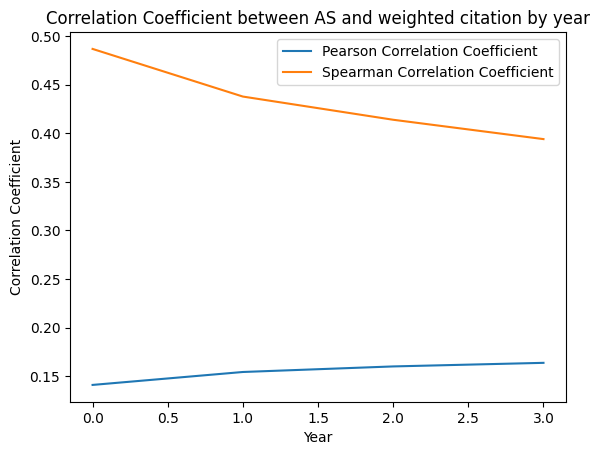

In [46]:
# Plot pearson correlation coefficient and spearman correlation coefficient between AS and weighted citation by year
pearson_correlation_coefficient_list = []
spearman_correlation_coefficient_list = []
for i in range(PREDICT_FOR_YEARS):
    pearson_correlation_coefficient_list.append(pearson_correlation_coefficient(AS[i+1].float(), weighted_citation[i].float()))
    spearman_correlation_coefficient_list.append(spearman_correlation_coefficient(AS[i+1].float(), weighted_citation[i].float()))

pearson_correlation_coefficient_list_cpu = [item.cpu().numpy() for item in pearson_correlation_coefficient_list]
spearman_correlation_coefficient_list_cpu = [item.cpu().numpy() for item in spearman_correlation_coefficient_list]

plt.xlabel('Year')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient between AS and weighted citation by year')
plt.plot(pearson_correlation_coefficient_list_cpu, label='Pearson Correlation Coefficient')
plt.plot(spearman_correlation_coefficient_list_cpu, label='Spearman Correlation Coefficient')
plt.legend()
plt.show()